<a href="https://colab.research.google.com/github/plaban1981/Fastai/blob/master/Parkinsons_Disease_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/sayakpaul/Parkinson-s-Disease-Classifier

# Detecting Parkinson’s with OpenCV, Computer Vision, and the Spiral/Wave Test

https://www.pyimagesearch.com/2019/04/29/detecting-parkinsons-disease-with-opencv-computer-vision-and-the-spiral-wave-test/


In this tutorial, you will learn how to use OpenCV and machine learning to automatically detect Parkinson’s disease in hand-drawn images of spirals and waves.

Today’s tutorial is inspired from PyImageSearch reader, Joao Paulo Folador, a PhD student from Brazil.

Joao is interested in utilizing computer vision and machine learning to automatically detect and predict Parkinson’s disease based on geometric drawings (i.e., spirals and sign waves).

Detect stages of parkinsons based on a set of geometric drawings, associated paper - Distinguishing Different Stages of Parkinson’s Disease Using Composite Index of Speed and Pen-Pressure of Sketching a Spiral, by Zham et al in 2017.

The researchers found that the drawing speed was slower and the pen pressure lower among Parkinson’s patients — this was especially pronounced for patients with a more acute/advanced forms of the disease.

One of the symptoms of Parkinson’s is tremors and rigidity in the muscles, making it harder to draw smooth spirals and waves.

Joao postulated that it might be possible to detect Parkinson’s disease using the drawings alone rather than having to measure the speed and pressure of the pen on paper.

Reducing the requirement of tracking pen speed and pressure:

Eliminates the need for additional hardware when performing the test.
Makes it far easier to automatically detect Parkinson’s.
Graciously, Joao and his advisor allowed me access to the dataset they collected of both spirals and waves drawn by 

* (1) patients with Parkinson’s, and 
* (2) healthy participants.

I took a look at the dataset and considered our options.

Here we would be applying two methods :
* apply deep learning (fastai)

* apply computer vision and OpenCV to detect Parkinson’s based on geometric drawings



# Detecting Parkinson’s with OpenCV, Computer Vision, and the Spiral/Wave Test

Import Libraries

In [99]:
from sklearn.ensemble import RandomForestClassifier
#to encode labels as integers
from sklearn.preprocessing import LabelEncoder
# derive raw accuracy, sensitivity, and specificity.
from sklearn.metrics import confusion_matrix
# Histogram of Oriented Gradients (HOG) will come from the feature package
from skimage import feature
# import will help us for visualization
from imutils import build_montages
# import will help us to extract the file paths to each of the images
from imutils import paths
import numpy as np
# import will allow us to parse command line arguments.
import argparse
# cv2 will be used to read, process, and display images
import cv2
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# define a function to quantify a wave/spiral image  with the HOG method

In [100]:
def quantify_image(image):
	# compute the histogram of oriented gradients feature vector for
	# the input image
	features = feature.hog(image, orientations=9,
		pixels_per_cell=(10, 10), cells_per_block=(2, 2),
		transform_sqrt=True, block_norm="L1")
	# return the feature vector
	return features

# The load_split  function has a goal of accepting a dataset path  and returning all feature data  and associated class labels 

In [101]:
def load_split(path):
	# grab the list of images in the input directory, then initialize
	# the list of data (i.e., images) and class labels
	imagePaths = list(paths.list_images(path))
	data = []
	labels = []
	# loop over the image paths
	for imagePath in imagePaths:
		# extract the class label from the filename
		label = imagePath.split(os.path.sep)[-2]
		# load the input image, convert it to grayscale, and resize
		# it to 200x200 pixels, ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image = cv2.resize(image, (200, 200))
		# threshold the image such that the drawing appears as white
		# on a black background
		image = cv2.threshold(image, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		# quantify the image
		features = quantify_image(image)
		# update the data and labels lists, respectively
		data.append(features)
		labels.append(label)
	# return the data and labels
	return (np.array(data), np.array(labels))

In [ ]:
! unzip "/content/drive/My Drive/PyimageSearch/detect-parkinsons.zip" -d "/content/drive/My Drive/PyimageSearch/"

Archive:  /content/drive/My Drive/PyimageSearch/detect-parkinsons.zip
   creating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/
   creating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/
   creating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/
   creating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/testing/
   creating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/testing/healthy/
  inflating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/testing/healthy/V01HE01.png  
  inflating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/testing/healthy/V02HE01.png  
  inflating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/testing/healthy/V03HE1.png  
  inflating: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/testing/healthy/V04HE01.png  
  inflating: /content/drive/My Drive/PyimageSear

In [ ]:
os.listdir("/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset")

['spiral', 'wave']

The dataset itself consists of 204 images and is pre-split into a training set and a testing set, consisting of:

* Spiral: 102 images, 72 training, and 30 testing

* Wave: 102 images, 72 training, and 30 testing

In [102]:
path_spiral = "/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral"
path_wave = "/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/wave"

# Extract Train and Test Features for spiral images 

In [104]:
args = {'dataset': path_spiral, 'trials': 5}
args1 = {'dataset': path_wave, 'trials': 5}

In [105]:
# define the path to the training and testing directories
trainingPath = os.path.sep.join([args["dataset"], "training"])
testingPath = os.path.sep.join([args["dataset"], "testing"])
trainingPath1 = os.path.sep.join([args1["dataset"], "training"])
testingPath1 = os.path.sep.join([args1["dataset"], "testing"])

In [106]:
trainingPath,trainingPath1

('/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral/training',
 '/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/wave/training')

In [107]:
(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)
(trainX1, trainY1) = load_split(trainingPath1)
(testX1, testY1) = load_split(testingPath1)

In [108]:
trainX.shape,testX.shape

((72, 12996), (30, 12996))

In [109]:
trainX1.shape,testX1.shape

((72, 12996), (30, 12996))

In [110]:
# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)
trainY1 = le.fit_transform(trainY1)
testY1 = le.transform(testY1)
# initialize our trials dictionary
trials = {}

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

## Train the model and evaluate on the test images

[INFO] training model 1 of 5...


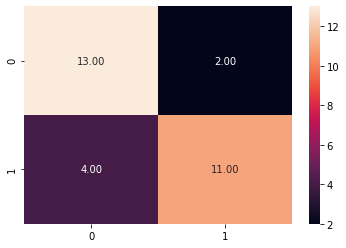

[INFO] training model 2 of 5...


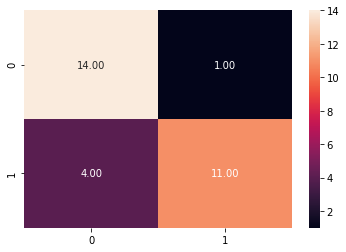

[INFO] training model 3 of 5...


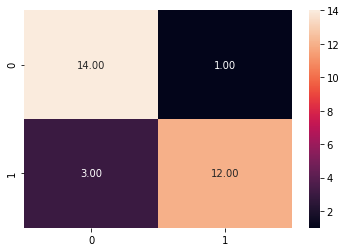

[INFO] training model 4 of 5...


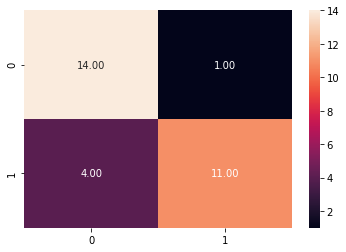

[INFO] training model 5 of 5...


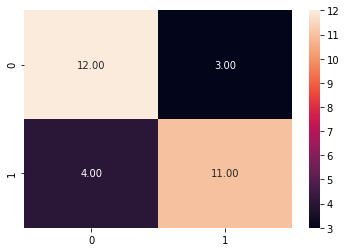

acc
===
u=0.8200, o=0.0340

sensitivity
u=0.7467, o=0.0267

specificity
u=0.8933, o=0.0533



In [112]:
# initialize our trials dictionary
trials = {}

# loop over the number of trials to run
for i in range(0, args["trials"]):
	# train the model
	print("[INFO] training model {} of {}...".format(i + 1,
		args["trials"]))
	model = RandomForestClassifier(n_estimators=100)
	model.fit(trainX, trainY)

	# make predictions on the testing data and initialize a dictionary
	# to store our computed metrics
	predictions = model.predict(testX)
	metrics = {}

	# compute the confusion matrix and and use it to derive the raw
	# accuracy, sensitivity, and specificity
	cm = confusion_matrix(testY, predictions).flatten();sns.heatmap(confusion_matrix(testY, predictions),annot=True,fmt='.2f');plt.show()
	(tn, fp, fn, tp) = cm
	metrics["acc"] = (tp + tn) / float(cm.sum())
	metrics["sensitivity"] = tp / float(tp + fn)
	metrics["specificity"] = tn / float(tn + fp)

	# loop over the metrics
	for (k, v) in metrics.items():
		# update the trials dictionary with the list of values for
		# the current metric
		l = trials.get(k, [])
		l.append(v)
		trials[k] = l

# loop over our metrics
for metric in ("acc", "sensitivity", "specificity"):
	# grab the list of values for the current metric, then compute
	# the mean and standard deviation
	values = trials[metric]
	mean = np.mean(values)
	std = np.std(values)

	# show the computed metrics for the statistic
	print(metric)
	print("=" * len(metric))
	print("u={:.4f}, o={:.4f}".format(mean, std))
	print("")


Validation Accuracy for Spiral images is 82%

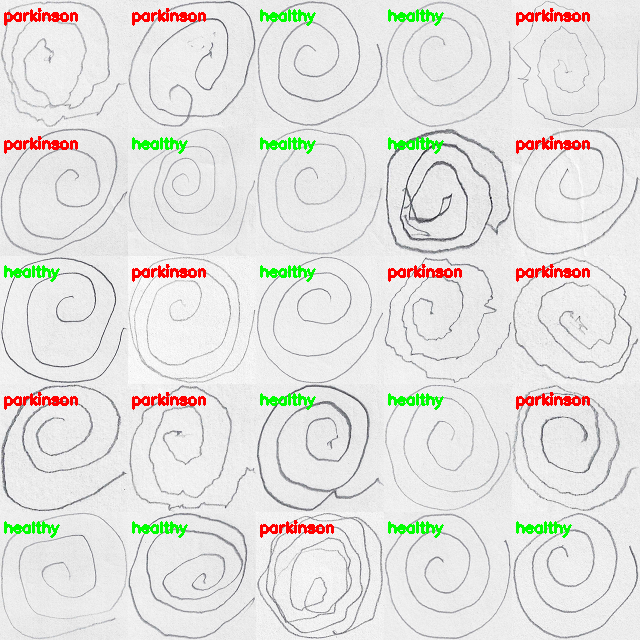

-1

In [113]:
from google.colab.patches import cv2_imshow
# randomly select a few images and then initialize the output images
# for the montage
testingPaths = list(paths.list_images(testingPath))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# loop over the testing samples
for i in idxs:
	# load the testing image, clone it, and resize it
	image = cv2.imread(testingPaths[i])
	output = image.copy()
	output = cv2.resize(output, (128, 128))

	# pre-process the image in the same manner we did earlier
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = cv2.resize(image, (200, 200))
	image = cv2.threshold(image, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

	# quantify the image and make predictions based on the extracted
	# features using the last trained Random Forest
	features = quantify_image(image)
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	# draw the colored class label on the output image and add it to
	# the set of output images
	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		color, 2)
	images.append(output)

# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)

# Extract Train and Test Features for Wave  images

In [114]:
args = {'dataset': path_wave, 'trials': 5}
# define the path to the training and testing directories
trainingPath = os.path.sep.join([args["dataset"], "training"])
testingPath = os.path.sep.join([args["dataset"], "testing"])
#
(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)
#
# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)
# initialize our trials dictionary
trials = {}

In [115]:
trainingPath

'/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/wave/training'

## Train the model on Wave images and Evaluate on Test images

[INFO] training model 1 of 5...


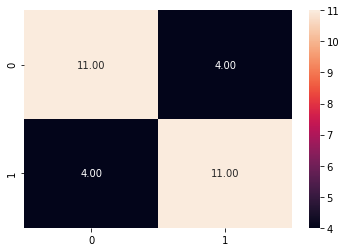

[INFO] training model 2 of 5...


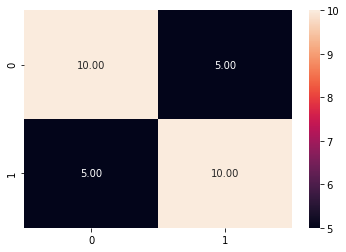

[INFO] training model 3 of 5...


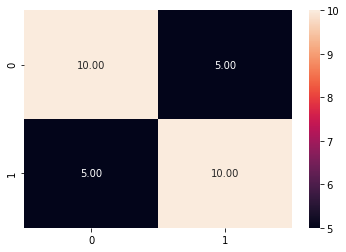

[INFO] training model 4 of 5...


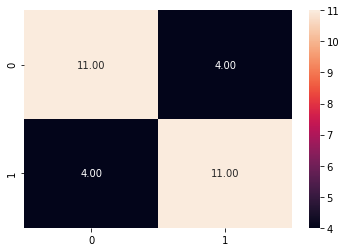

[INFO] training model 5 of 5...


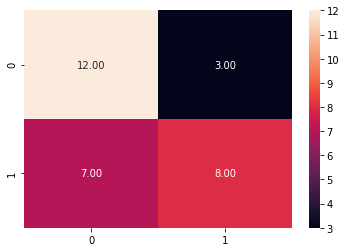

acc
===
u=0.6933, o=0.0327

sensitivity
u=0.6667, o=0.0730

specificity
u=0.7200, o=0.0499



In [116]:
# initialize our trials dictionary
trials = {}

# loop over the number of trials to run
for i in range(0, args["trials"]):
	# train the model
	print("[INFO] training model {} of {}...".format(i + 1,
		args["trials"]))
	model = RandomForestClassifier(n_estimators=100)
	model.fit(trainX, trainY)

	# make predictions on the testing data and initialize a dictionary
	# to store our computed metrics
	predictions = model.predict(testX)
	metrics = {}

	# compute the confusion matrix and and use it to derive the raw
	# accuracy, sensitivity, and specificity
	cm = confusion_matrix(testY, predictions).flatten();sns.heatmap(confusion_matrix(testY, predictions),annot=True,fmt='.2f');plt.show()
	(tn, fp, fn, tp) = cm
	metrics["acc"] = (tp + tn) / float(cm.sum())
	metrics["sensitivity"] = tp / float(tp + fn)
	metrics["specificity"] = tn / float(tn + fp)

	# loop over the metrics
	for (k, v) in metrics.items():
		# update the trials dictionary with the list of values for
		# the current metric
		l = trials.get(k, [])
		l.append(v)
		trials[k] = l

# loop over our metrics
for metric in ("acc", "sensitivity", "specificity"):
	# grab the list of values for the current metric, then compute
	# the mean and standard deviation
	values = trials[metric]
	mean = np.mean(values)
	std = np.std(values)

	# show the computed metrics for the statistic
	print(metric)
	print("=" * len(metric))
	print("u={:.4f}, o={:.4f}".format(mean, std))
	print("")


## Validation Accuracy for wave images is 69%

Visualize Test Images Randomly

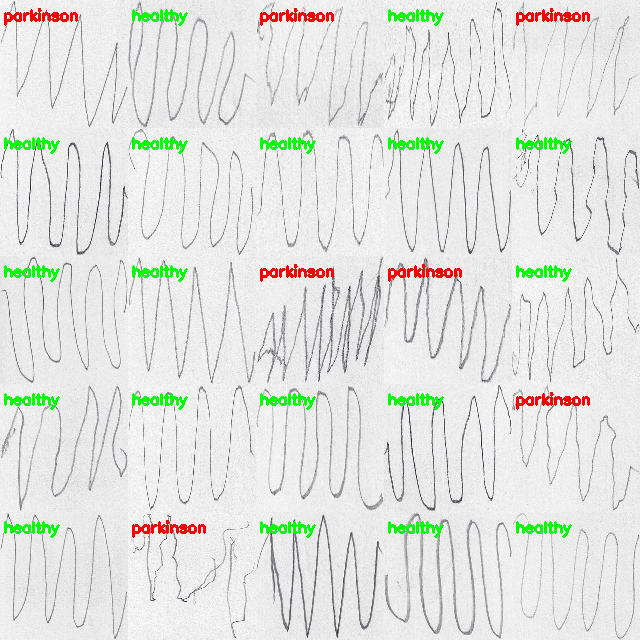

-1

In [117]:
from google.colab.patches import cv2_imshow
# randomly select a few images and then initialize the output images
# for the montage
testingPaths = list(paths.list_images(testingPath))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# loop over the testing samples
for i in idxs:
	# load the testing image, clone it, and resize it
	image = cv2.imread(testingPaths[i])
	output = image.copy()
	output = cv2.resize(output, (128, 128))

	# pre-process the image in the same manner we did earlier
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = cv2.resize(image, (200, 200))
	image = cv2.threshold(image, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

	# quantify the image and make predictions based on the extracted
	# features using the last trained Random Forest
	features = quantify_image(image)
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	# draw the colored class label on the output image and add it to
	# the set of output images
	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		color, 2)
	images.append(output)

# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)

# Parkinsons Disease Classifier : using FASTAI 

In [ ]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab|bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


Spiral Images

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
path_spiral = "/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral"
path_wave = "/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/wave"

# Enabling Transforms

Transforms are passed on when creating the **"ImageDataBunch"** objects.

Genearlly, you may enable the "Default" transforms by calling 
**tfms = get_transforms()**

In [13]:
tfms = get_transforms(max_rotate=180,flip_vert=True)
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-180, 180)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved

In [14]:
len(tfms)

2

The tuple contating transforms has 2 lists nested.

* One is for the training dataset.

* Second one is for the validation dataset that involves minimal transforms/just resizing.

In [15]:
tfms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-180, 180)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [16]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

# Loading and preparing the data with fastai's ImageDataBunch class

In [17]:
data = ImageDataBunch.from_folder(path_spiral,train='training',valid='testing',ds_tfms=tfms,size=256,bs=8).normalize(imagenet_stats)

# Class Labels

In [18]:
print(f"Class Labels for the training samples : {data.classes}")

Class Labels for the training samples : ['healthy', 'parkinson']


# Visualize the Data

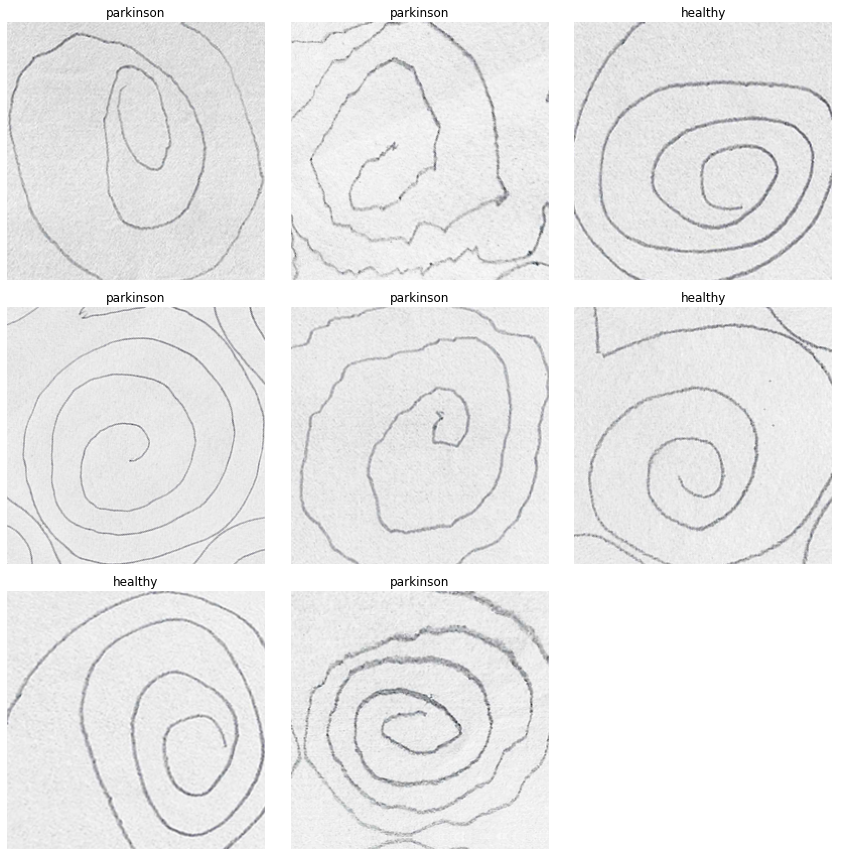

In [19]:
data.show_batch(rows=9,figsize=(12,12))

In [20]:
data

ImageDataBunch;

Train: LabelList (72 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral;

Valid: LabelList (30 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: /content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/spiral;

Test: None

# Train the Model

In [21]:
#Training with mixed precision
learn = cnn_learner(data, models.resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


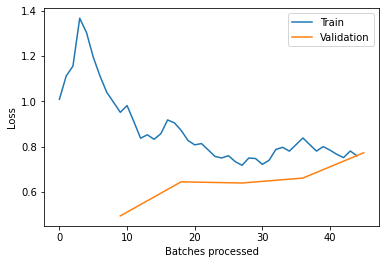

In [22]:
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

# Find the Optimum learning rate 

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


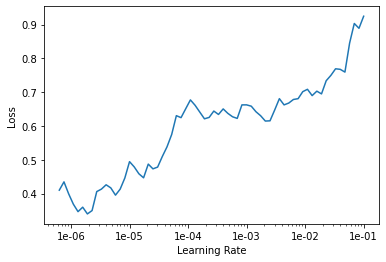

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5,max_lr =slice(1e-6,1e-6/5))

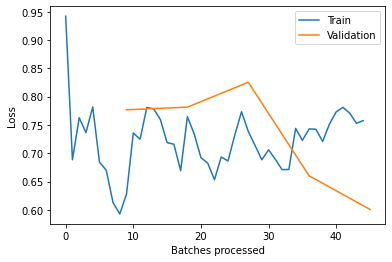

In [26]:
learn.recorder.plot_losses()

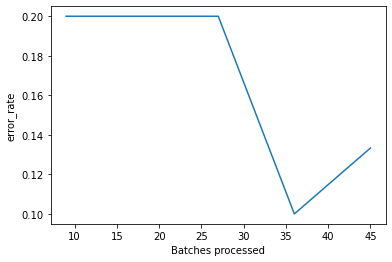

In [27]:
learn.recorder.plot_metrics()

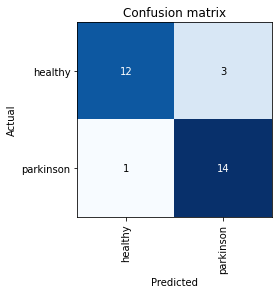

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Save the first trained model

In [29]:
learn.save('stage-1-rn34')

In [32]:
learn.load('stage-1-rn34')
preds,y = learn.get_preds(DatasetType.Train)
print(f"Training Acuracy :{accuracy(preds,y)}")

Training Acuracy :0.7638888955116272


In [33]:
preds,y = learn.get_preds(DatasetType.Valid)
print(f"Validation Acuracy :{accuracy(preds,y)}")

Validation Acuracy :0.8666666746139526


## Unfreeze the layers so that the weights can be updated through all layers

In [34]:
learn.unfreeze()
learn.fit_one_cycle(5)

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


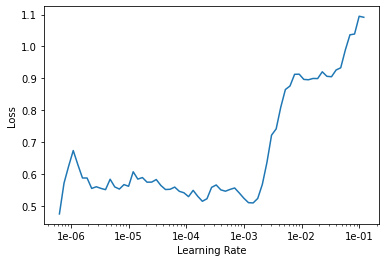

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(5,max_lr =slice(1e-5,1e-4/5))

In [38]:
learn.fit_one_cycle(5,max_lr =slice(1e-5,1e-5/5))

In [54]:
learn.fit_one_cycle(10,max_lr =slice(1e-4,1e-3/5))

In [55]:
learn.save('stage-2-rn34')

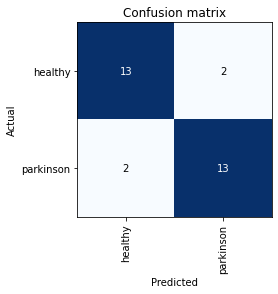

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [57]:
preds,y = learn.get_preds(DatasetType.Valid)
print(f"Validation Acuracy :{accuracy(preds,y)}")

Validation Acuracy :0.8666666746139526


# Visualize top losses

In [59]:
losses,idxs = interp.top_losses()

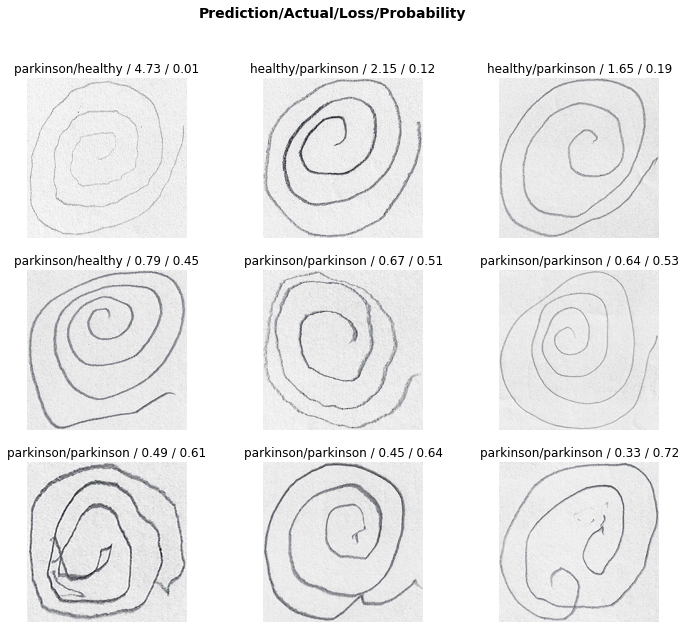

In [60]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

# Viualize Predictions for Spiral images

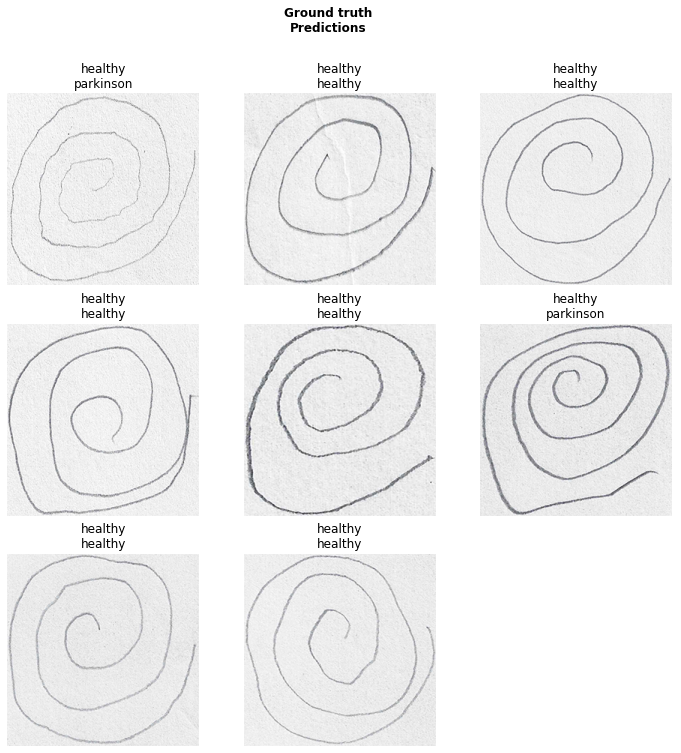

In [61]:
learn.show_results()

Let's  check if the accuracy increases by increasing the image pixel to  512 this time and see if we can push the score and robustness.

In [84]:
path_spiral ='/content/drive/My Drive/PyimageSearch/detect-parkinsons/dataset/wave'

In [88]:
data = ImageDataBunch.from_folder(path_spiral, ds_tfms=get_transforms(),train='training', valid='testing',size=224, bs=8).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5)

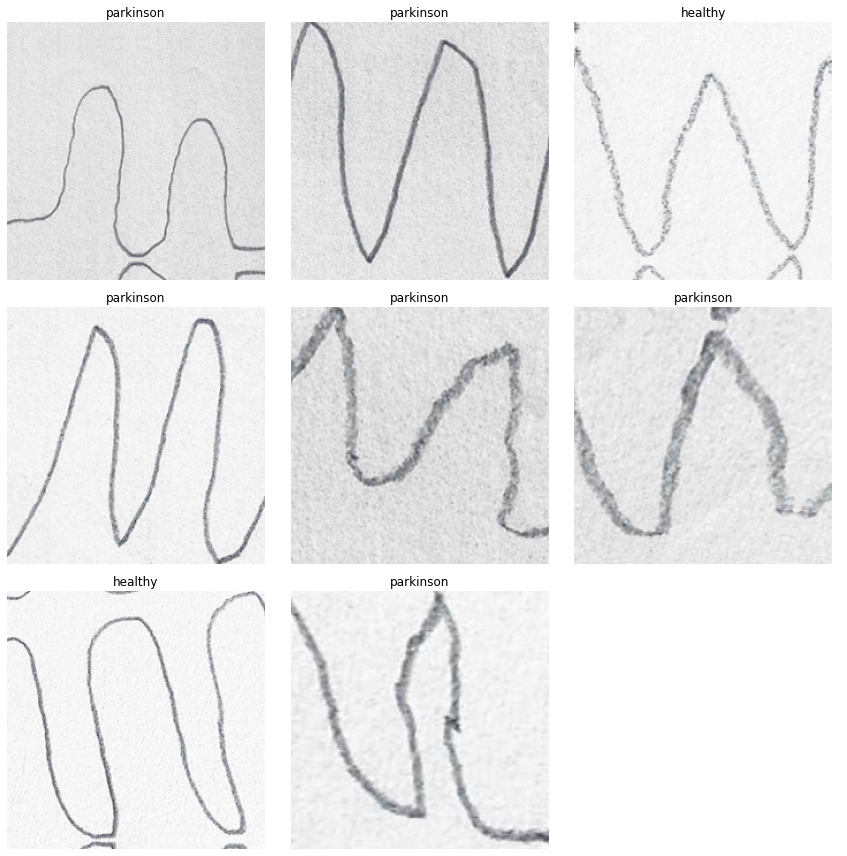

In [98]:
data.show_batch(rows=9,figsize=(12,12))

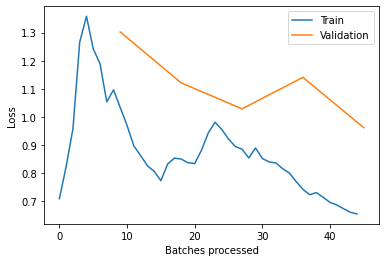

In [89]:
learn.recorder.plot_losses()

In [90]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


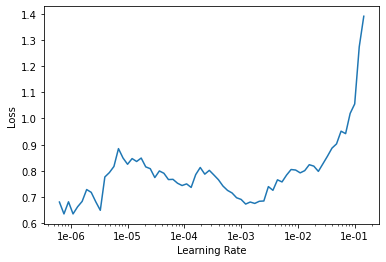

In [91]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(5,max_lr =slice(1e-4,1e-3))

In [93]:
learn.fit_one_cycle(5,max_lr =slice(1e-4,1e-3/5))

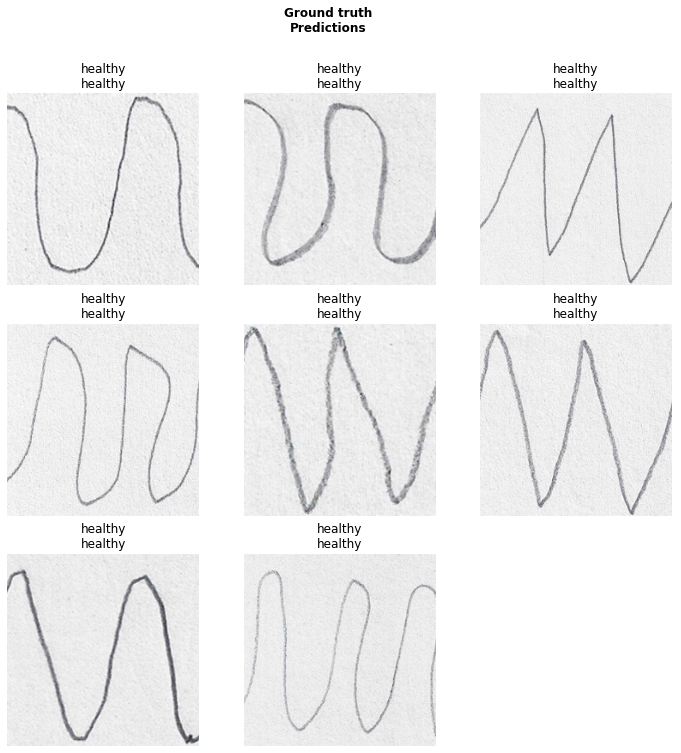

In [94]:
learn.show_results()

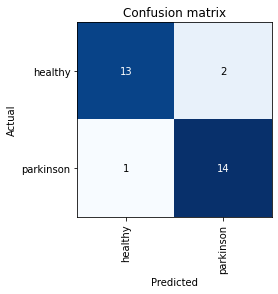

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [96]:
preds,y = learn.get_preds(DatasetType.Valid)


In [97]:
print(f'Test Accuracy : {accuracy(preds,y)}')

Test Accuracy : 0.8999999761581421


#### This accuracy is more than that of the Machine learning approach